# Imports

In [1]:
import sys; sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from database.dataset import INBreast_Dataset

from pathlib import Path
from tqdm import tqdm
import cv2
import os
import ast

from skimage import restoration
from dehazing import dehaze


def simple_im_show(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

def simple_im_show2(img, mask, figsize=(10, 10)):
    fig, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(mask, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()


In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_size_mm=2.0,
        extract_patches=False,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,

        return_indexes_in_mask=True
)

In [3]:
def bboxes_over_image(image, bboxes, colors, types, thickness=2, alpha=0.8):
    """Overimposes bboxes on the image.
    Can work with multiple groups of bboxes 
    Args:
        image (np.ndarray): Grayscale image for overimposition
        bboxes (List[np.ndarray]): List containing bboxes arrays.
            Each one of specific shape depending of bbox type:
                (n_bboxes, top_left_coord, top_right_coordinate) - rect
                    top_left_coord, top_right_coordinate - tuples with 2 integer coordinates
                (n_bboxes, centre_x, centre_y, radius) - circ
                    center coordinates and radiuses should be integers
            
        colors (list): List of colors to be assigned to the bboxes. BGR convention
        types (list): List of types: 'rect' OR 'circ'
    """
    img8  = (255*(image/image.max())).astype(np.uint8)
    img_bgr = cv2.cvtColor(img8,cv2.COLOR_GRAY2RGB)

    for bbox_group_idx, bbox_group in enumerate(bboxes):
        bbox_mask = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
        for bbox in bbox_group:
            if types[bbox_group_idx] == 'rect':
                bbox_mask = cv2.rectangle(bbox_mask, bbox[0], bbox[1], color=colors[bbox_group_idx], thickness=thickness)
            elif types[bbox_group_idx] == 'circ':
                bbox_mask = cv2.circle(bbox_mask, (bbox[0], bbox[1]),bbox[2], color=colors[bbox_group_idx], thickness=thickness)
        beta = 1 - alpha
        img_bgr = cv2.addWeighted(img_bgr, alpha, bbox_mask, beta, 0.0)
    return img_bgr

# Detection

In [4]:
def sobel_gradient(img):
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    return grad

def detect_mC(image):
    # 1. CONTRAST ENHANCEMENT - EQUALIZATION
    image = image.astype(np.float32)
    # OTHER NORMALIZATION MAYBE
    normalized_image = image/image.max()
    dehazed_image = dehaze(normalized_image, 0.9, 11, radius=40, eps=1e-5)
    # print("AFTER DEHAZING")
    # simple_im_show(dehazed_image)
    dehazed_image = image

    
    #  2. BACKGROUND EXTRACTION
    background = restoration.rolling_ball(dehazed_image, radius=50, )
    background_substracted = dehazed_image - background
    # print("AFTER background_substracted")
    # simple_im_show(background_substracted)

    # 3. SOBEL-GAUSSIAN-SOBEL
    sobel_f1 = sobel_gradient(background_substracted)
    blured_iamge = cv2.GaussianBlur(sobel_f1,(0,0),2)
    sobel_f2 = sobel_gradient(blured_iamge)
    # print("AFTER SOBEL-GAUSSIAN-SOBEL")
    simple_im_show(sobel_f2)

    # 4. BOUNDARY CLEANING
    breast_mask = (image!=0).astype(np.uint8)
    erosion_size = 6
    structuring_element = cv2.getStructuringElement(cv2.MARKER_CROSS, (erosion_size, erosion_size))
    breast_boundary_mask = (breast_mask - cv2.erode(breast_mask, structuring_element, iterations=20))
    breast_boundary_mask = cv2.dilate(breast_boundary_mask, structuring_element,  iterations=15)
    sobel_f2[breast_boundary_mask>0] = 0

    # print("AFTER BOUNDARY CLEANING")
    # simple_im_show(breast_boundary_mask)
    # simple_im_show(sobel_f2)

    # 5. FIRST GLOBAL THRESHOLDING
    alpha1 = 0.97
    # !!!SELECT FOR EVALUATION ONLY BREAST PIXELS!!!
    alpha1_intensity = np.quantile(sobel_f2, q=alpha1)
    sobel_f2[sobel_f2 <= alpha1_intensity] = 0
    # print("AFTER FIRST GLOBAL THRESHOLDING")
    # simple_im_show(sobel_f2)

    # 6. FIRST HOUGH

    rmin = 1
    rmax = 20
    gradient_normalized = (255*(sobel_f2/np.max(sobel_f2))).astype(np.uint8)
    # simple_im_show(gradient_normalized)

    circles = cv2.HoughCircles(gradient_normalized, cv2.HOUGH_GRADIENT_ALT, dp=1, minDist=10,
                               param1=300, param2=0.6,
                               minRadius=rmin, maxRadius=rmax)
    # # 7. SECOND HOUGH
    # for circle in circles[0]:
        


    # alpha2 = 0.95
    return circles, gradient_normalized


What can I check for the first step of contrast enhancment except dehazing/linear stretching?
Automatic breast boundary clearing.
Does my saturation make sense? 
Why Hough might not work?

In [5]:
def quick_circle_comparison(true_bboxes, predicted_roi_circles, mask):
    TP = set()
    FP = []

    true_mask = np.zeros(mask.shape)
    for tbbox_idx, tbbox in enumerate(true_bboxes):
        true_mask[ tbbox[0][1]:tbbox[1][1], tbbox[0][0]:tbbox[1][0]] = tbbox_idx


    for circle_idx, circle in tqdm(enumerate(predicted_roi_circles.astype(int)), total=len(predicted_roi_circles)):
        circle_roi_mask = cv2.circle(np.zeros(mask.shape), (circle[0], circle[1]), circle[2], 1, -1).astype(np.bool8)
        mapped_rois_idxs = set(np.unique(true_mask[circle_roi_mask])).difference(set([0]))
        if len(mapped_rois_idxs)>0:
            TP = TP.union(mapped_rois_idxs)
        else:
            FP.append(circle_idx)
    return TP, FP


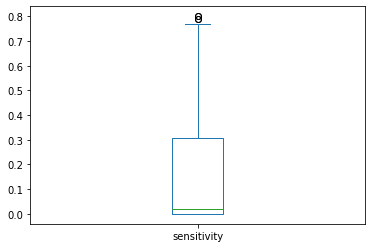

,TP,FP,FN,predicted_roi_circles,sensitivity
131,0,10,1,"[[2113.0, 1713.0, 13.78028], [2140.0, 1750.0, ...",0.0
81,0,12,21,"[[586.0, 2707.0, 12.967199], [232.0, 3232.0, 1...",0.0
157,0,6,5,"[[848.0, 718.0, 10.598018], [309.0, 2749.0, 14...",0.0
79,0,13,19,"[[911.0, 655.0, 14.092958], [334.0, 2996.0, 13...",0.0
129,0,12,1,"[[2287.0, 2201.0, 15.5572815], [1121.0, 740.0,...",0.0
...,...,...,...,...,...
103,20,4,6,"[[666.0, 2012.0, 13.323768], [790.0, 1559.0, 1...",0.769231
178,75,12,20,"[[1230.0, 2122.0, 15.032671], [1172.0, 1927.0,...",0.789474
47,15,11,4,"[[445.0, 2230.0, 12.164411], [1000.0, 2014.0, ...",0.789474
97,12,2,3,"[[70.0, 1277.0, 13.8153515], [66.0, 1514.0, 13...",0.8


In [6]:
some_results = pd.read_pickle('results1.pkl')
some_results['sensitivity'] = some_results.TP / (some_results.TP + some_results.FN)
some_results.sensitivity.plot.box()
plt.show()
some_results.sort_values(by=['sensitivity'])

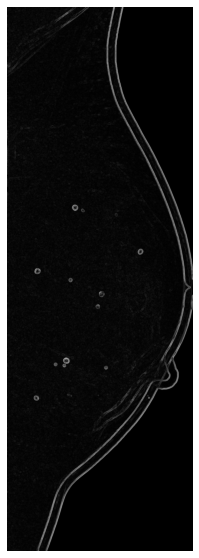

100%|██████████| 16/16 [00:00<00:00, 174.83it/s]

{'TP': 12, 'FP': 4, 'FN': 3}


In [7]:
# bad 81
# good 99

idx = 99
mask = db[idx]['lesion_mask']
image = db[idx]['img']
true_bboxes = db[idx]['lesion_bboxes']

predicted_roi_circles, processed_image = detect_mC(image)
predicted_roi_circles = predicted_roi_circles[0]

TP, FP = quick_circle_comparison(true_bboxes, predicted_roi_circles, mask)
FN = len(true_bboxes) - len(TP)

results = {'TP':len(TP), 'FP':len(FP), 'FN':FN}
print(results)


# Evaluations

In [8]:
alt_predicted_roi_circles = cv2.HoughCircles(processed_image, cv2.HOUGH_GRADIENT, dp=1, minDist=10,
                            param1=300, param2=2,
                            minRadius=1, maxRadius=20)
alt_predicted_roi_circles = alt_predicted_roi_circles[0]

TP, FP = quick_circle_comparison(true_bboxes, alt_predicted_roi_circles, mask)
FN = len(true_bboxes) - len(TP)

results = {'TP':len(TP), 'FP':len(FP), 'FN':FN}
print(results)

100%|██████████| 575/575 [00:03<00:00, 168.41it/s]

{'TP': 11, 'FP': 388, 'FN': 4}


In [9]:
processed_image = 255*(processed_image>0)

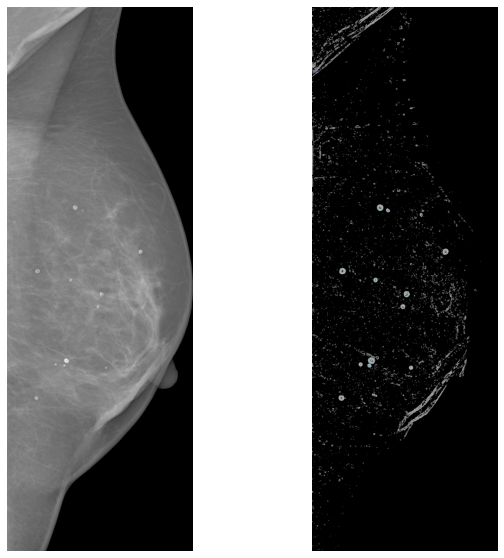

In [10]:
results_plot =  bboxes_over_image(processed_image, [true_bboxes, predicted_roi_circles.astype(int)], [(0, 255, 0), (0, 0, 255)], ['rect', 'circ'])
cv2.imwrite('results_plot.png', results_plot)
simple_im_show2(image, results_plot)